In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2


In [23]:

# Function to parse data from a file
def parse_data(file_path):
    sequences = []
    labels = []
    with open(file_path, "r") as file:
        for line in file:
            cleaned_line = line.strip()
            if cleaned_line in {"end", "<end>"}:
                sequences.append("end")
                labels.append("end")
            elif len(cleaned_line.split()) == 2:
                parts = cleaned_line.split()
                sequences.append(parts[0])  # Amino acid
                labels.append(parts[1])  # Secondary structure label
            else:
                continue  # Skip any malformed lines
    return sequences, labels

# Function to encode sequences
def encode_sequences(sequences):
    amino_acid_mapping = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, 'end': 20}
    encoded_seqs = np.zeros((len(sequences), 21))
    for idx, amino_acid in enumerate(sequences):
        encoded_seqs[idx, amino_acid_mapping[amino_acid]] = 1
    return encoded_seqs

# Function to encode labels
def encode_labels(labels):
    label_mapping = {'e': 0, 'h': 1, '_': 2, 'end': 3}
    encoded_labels = np.zeros((len(labels), 3))  # No need for encoding 'end'
    for idx, label in enumerate(labels):
        if label != 'end':
            encoded_labels[idx, label_mapping[label]] = 1
    return encoded_labels

# Load and process training and test data
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")


eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)


In [24]:

# Function to create sliding windows
def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows

# Prepare windowed input for model
windowed_input_train = create_sliding_windows(np.array(eseq_train))
windowed_input_test = create_sliding_windows(np.array(eseq_test))

def build_first_network(input_shape):
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Hidden layer with 40 units
        Dense(3, activation='softmax')  # Output layer for the three types of secondary structures
    ])
    model.compile(optimizer=SGD(),  # Stochastic gradient descent optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
def build_second_network():
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(3,)),  # Input shape matches the output of the first network
        Dense(3, activation='softmax')  # Same output configuration as the first network
    ])
    model.compile(optimizer=SGD(),  # Using the same optimizer as the first network
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
def train_cascade(first_model, second_model, X_train, y_train, X_test, y_test):
    # Train the first model and save the history
    history1 = first_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    
    # Generate intermediate outputs from the first model
    intermediate_output = first_model.predict(X_train)
    
    # Train the second model using the outputs of the first model as inputs, and save the history
    history2 = second_model.fit(intermediate_output, y_train, epochs=50, validation_data=(first_model.predict(X_test), y_test))
    
    return history1, history2



In [25]:
X_train = windowed_input_train
y_train = elab_train
X_test = windowed_input_test
y_test = elab_test

# Define and train models
first_network = build_first_network(input_shape=X_train.shape[1])
second_network = build_second_network()

# Train both models and get their histories
history1, history2 = train_cascade(first_network, second_network, X_train, y_train, X_test, y_test)

# Evaluate models
intermediate_output_test = first_network.predict(X_test)
test_loss, test_accuracy = second_network.evaluate(intermediate_output_test, y_test)
print("Test accuracy:", test_accuracy)

Epoch 1/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9940 - accuracy: 0.5420 - val_loss: 0.9953 - val_accuracy: 0.5440
Epoch 2/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9889 - accuracy: 0.5423 - val_loss: 0.9907 - val_accuracy: 0.5440
Epoch 3/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9841 - accuracy: 0.5423 - val_loss: 0.9879 - val_accuracy: 0.5440
Epoch 4/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9794 - accuracy: 0.5423 - val_loss: 0.9821 - val_accuracy: 0.5440
Epoch 5/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9743 - accuracy: 0.5423 - val_loss: 0.9777 - val_accuracy: 0.5440
Epoch 6/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9693 - accuracy: 0.5423 - val_loss: 0.9742 - val_accuracy: 0.5440
Epoch 7/50
569/569 [==============================] - 1s 1ms/step - loss: 0.9636 - accuracy: 0.5423 - val_loss: 0.9693 - val_accuracy: 0.5440
Epoch 

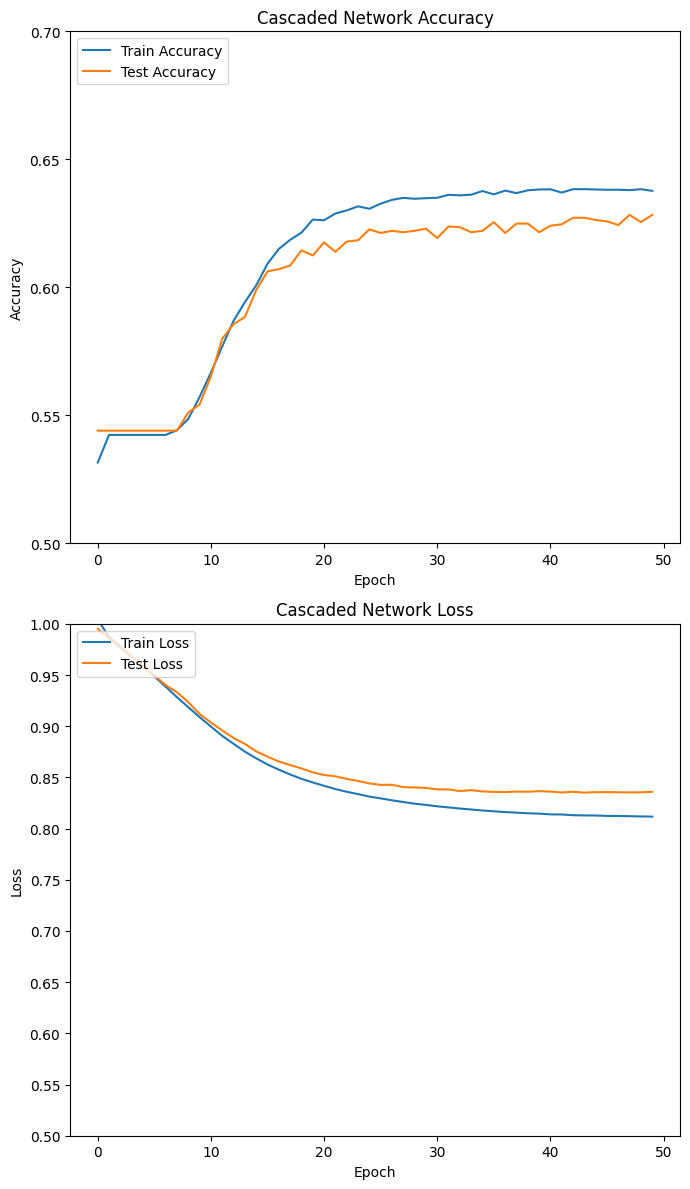

In [34]:

plt.figure(figsize=(7, 12))  # Adjusted figure size for vertical layout

# Subplot for the accuracy of second model
plt.subplot(2, 1, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Test Accuracy')
plt.title('Cascaded Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.5,0.7)
plt.yticks(np.arange(0.5, 0.705, 0.05))
# Subplot for the loss of second model
plt.subplot(2, 1, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('Cascaded Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.5,1)
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.tight_layout()
plt.show()

111/111 [==============================] - 0s 709us/step


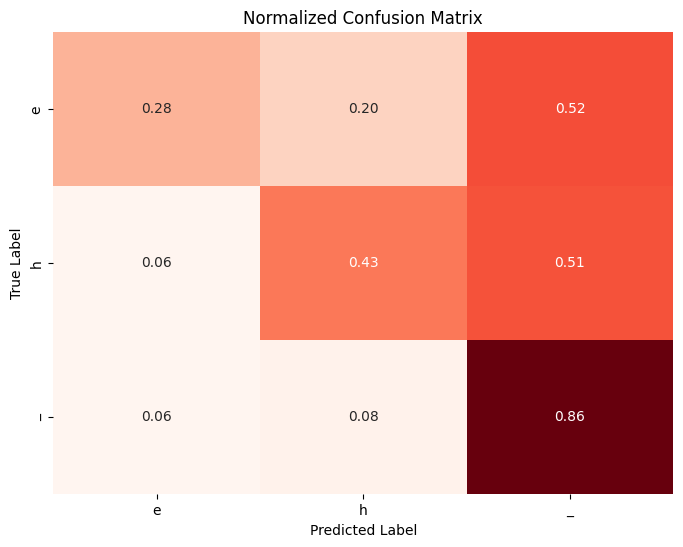

In [27]:
y_pred = second_network.predict(intermediate_output_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Use the encoded labels for y_test

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['e', 'h', '_']

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Reds', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [46]:


# Function to create sliding windows
def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size] for i in range(len(encoded_seqs))])
    return windows

# Assuming the presence of functions parse_data, encode_sequences, and encode_labels
# Load and process training data
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
windowed_input_train = create_sliding_windows(np.array(eseq_train), window_size=13)

# Load and process testing data
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)
windowed_input_test = create_sliding_windows(np.array(eseq_test), window_size=13)

# Function to build the second model (cascade)
def build_second_model(input_shape):
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Input shape matches the output of the first network
        Dense(3, activation='sigmoid')  # Same output configuration as the first network
    ])
    model.compile(optimizer=Adam(),  # Using Adam optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming the presence of the train_cascade function

# Build the first model (Convolutional Neural Network)
def build_improved_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=6, activation='sigmoid', input_shape=(input_shape[0], input_shape[1]),
               kernel_regularizer=l2(0.01)),  # Single Conv1D layer with increased filters and L2 regularization
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(40, activation='sigmoid', kernel_regularizer=l2(0.01)),  # L2 regularization on Dense layer
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(3, activation='sigmoid')
    ])
    optim = Adam(learning_rate=0.0001)  # Optimizer with a conservative learning rate
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the cascade architecture
def build_cascade_model(first_model, second_model):
    # Train the first model
    history1 = first_model.fit(windowed_input_train, elab_train, epochs=25, validation_data=(windowed_input_test, elab_test), batch_size=32)
    
    # Generate intermediate outputs from the first model
    intermediate_output = first_model.predict(windowed_input_train)
    
    # Train the second model using the outputs of the first model
    history2 = second_model.fit(intermediate_output, elab_train, epochs=25, validation_data=(first_model.predict(windowed_input_test), elab_test), batch_size=32)
    
    return history1, history2

# Build and train both models
better_first_model = build_improved_model(windowed_input_train.shape[1:])
better_second_model = build_second_model(better_first_model.output_shape[1])
better_history1, better_history2 = build_cascade_model(better_first_model, better_second_model)

# Evaluate the cascade architecture
intermediate_output_test = better_first_model.predict(windowed_input_test)
test_loss, test_accuracy = better_second_model.evaluate(intermediate_output_test, elab_test)
print("Test accuracy:", test_accuracy)


Epoch 1/25
569/569 [==============================] - 2s 3ms/step - loss: 1.8836 - accuracy: 0.5082 - val_loss: 1.6408 - val_accuracy: 0.5440
Epoch 2/25
569/569 [==============================] - 1s 2ms/step - loss: 1.5292 - accuracy: 0.5521 - val_loss: 1.3764 - val_accuracy: 0.5652
Epoch 3/25
569/569 [==============================] - 1s 3ms/step - loss: 1.3160 - accuracy: 0.5761 - val_loss: 1.2128 - val_accuracy: 0.5975
Epoch 4/25
569/569 [==============================] - 1s 2ms/step - loss: 1.1810 - accuracy: 0.5846 - val_loss: 1.1072 - val_accuracy: 0.6110
Epoch 5/25
569/569 [==============================] - 1s 2ms/step - loss: 1.0859 - accuracy: 0.5941 - val_loss: 1.0380 - val_accuracy: 0.6195
Epoch 6/25
569/569 [==============================] - 1s 2ms/step - loss: 1.0288 - accuracy: 0.6017 - val_loss: 0.9925 - val_accuracy: 0.6178
Epoch 7/25
569/569 [==============================] - 1s 2ms/step - loss: 0.9911 - accuracy: 0.6026 - val_loss: 0.9619 - val_accuracy: 0.6204
Epoch 

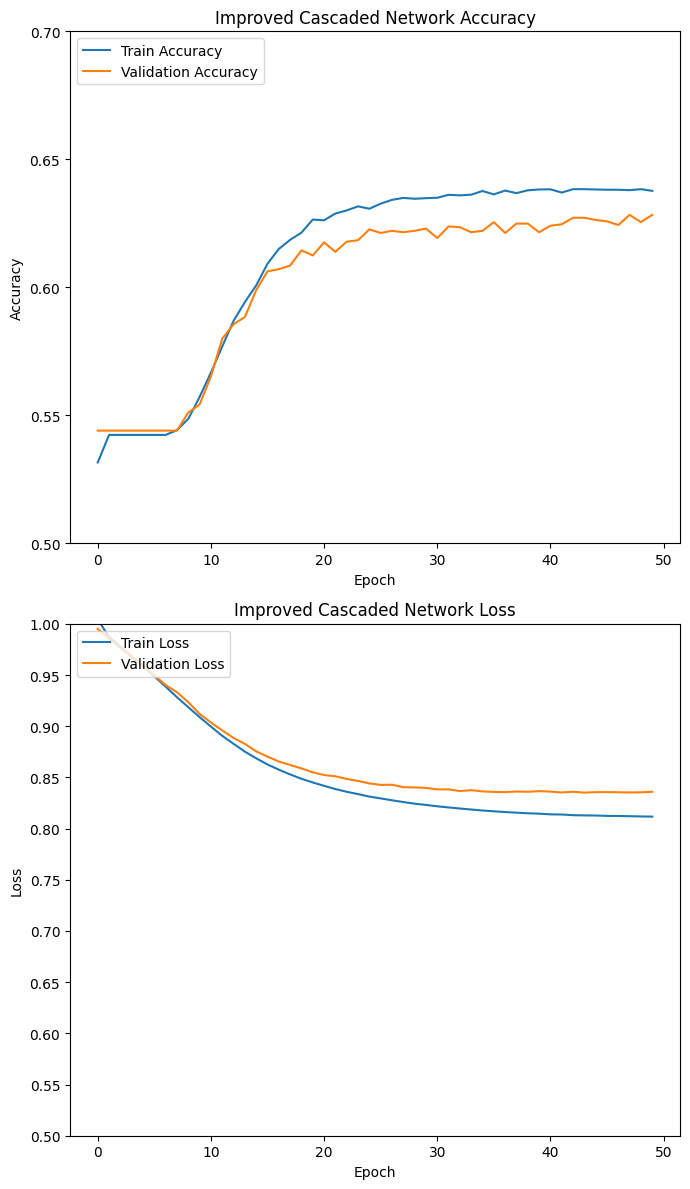

In [33]:
# Set up a figure to host two subplots vertically
plt.figure(figsize=(7, 12))  # Adjusted figure size for vertical layout

# Subplot for the accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot (top)
plt.plot(history2.history['accuracy'], label='Train Accuracy')  # Use history2 for the second model
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')  # Use history2 for the second model
plt.title('Improved Cascaded Network Accuracy')  # Update the title
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.5,0.7)
plt.yticks(np.arange(0.5, 0.705, 0.05))
# Subplot for the loss
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot (bottom)
plt.plot(history2.history['loss'], label='Train Loss')  # Use history2 for the second model
plt.plot(history2.history['val_loss'], label='Validation Loss')  # Use history2 for the second model
plt.title('Improved Cascaded Network Loss')  # Update the title
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.5,1)
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


111/111 [==============================] - 0s 982us/step


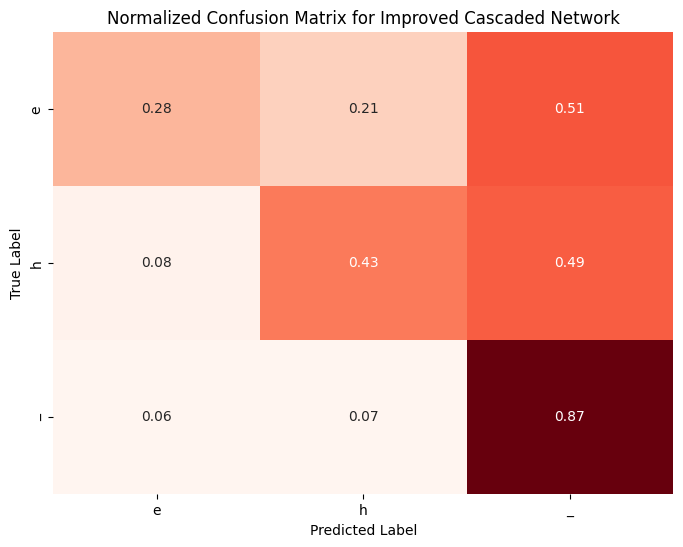

In [30]:
# Predict using the second network (Improved Cascaded Network)
y_pred = second_network.predict(intermediate_output_test)  # Use intermediate_output_test from the cascade architecture
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(elab_test, axis=1)  # Use the encoded labels for elab_test

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['e', 'h', '_']

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Reds', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix for Improved Cascaded Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


730/730 [==============================] - 1s 866us/step - loss: 0.9043 - accuracy: 0.5881
Original Cascade Model Test accuracy on unseen data: 0.5880841016769409
730/730 [==============================] - 1s 871us/step - loss: 0.8754 - accuracy: 0.6099
Improved Cascade Model Test accuracy on unseen data: 0.6098856329917908
730/730 [==============================] - 1s 763us/step


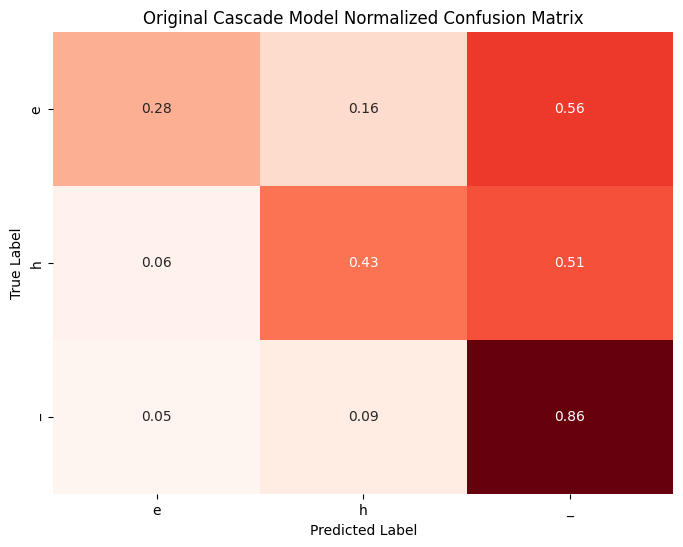

730/730 [==============================] - 1s 734us/step


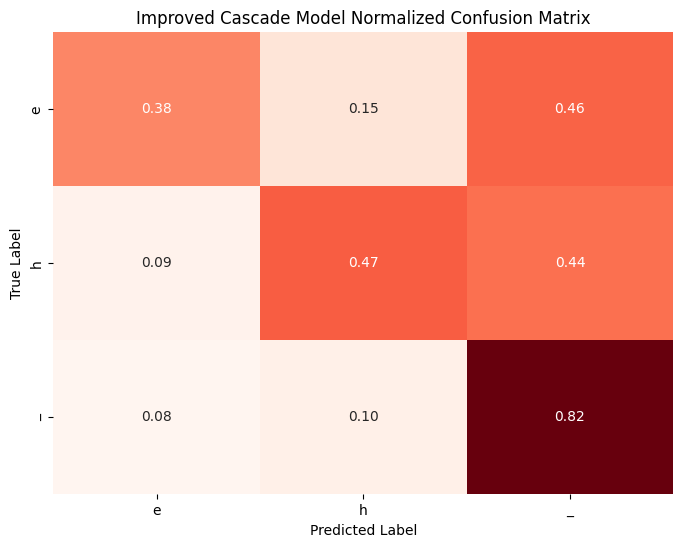

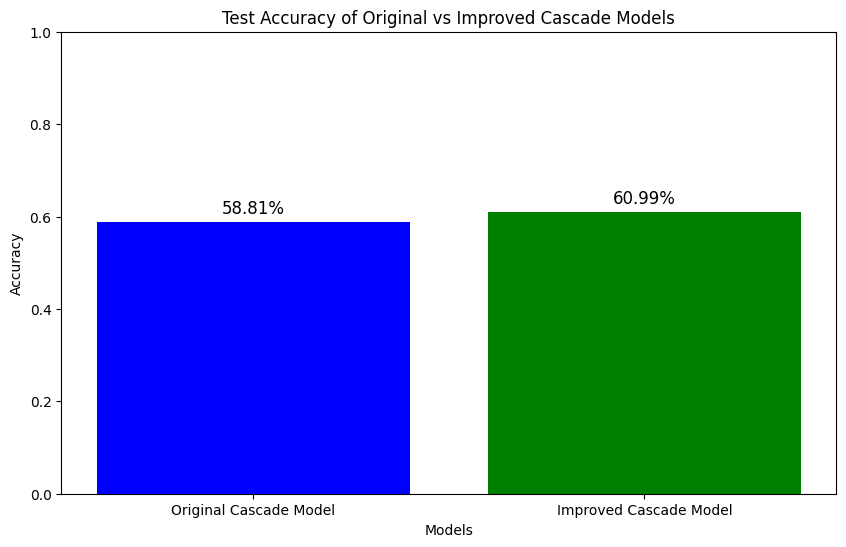

In [31]:

#Test on unseen data sheets
#RS126Data, C : loops
#H : Helix
#E : Stand

# Load and process testing data
def parse_unseen_data(file_path):
    '''
    There is 150 instance and every instance contain 2 line .
    1st line = primary sequence (amino acid)
    2nd line = secondary sequence (C,H,E)
    #FNKEQQNAFYEILHLPNLNEEQRNGFIQSLKDDPSQSANLLAE
    CCCCHHHHHHHHHCCCCCCCHHHHHHHHHHHHCCCCCCCCCCC'''
    sequences = []
    labels = []
 
    with open(file_path, "r") as file:
        # Read the file line by line
        lines = file.readlines()
        #print(len(lines)    )
        # Iterate over the lines, 2 at a time
        primary = True
        for line in lines:
            cleaned_line = line.strip()
            if primary:
                for charac in cleaned_line:
                    sequences.append(charac)
                #sequences.append("end")
                primary = False
            else:
                for charac in cleaned_line:
                    labels.append(charac)
                #labels.append("end")
                primary = True
    

    return sequences, labels

def convert_unseen_labels(labels):
    '''
    Convert unseen labels to numerical format.
    C : _
    H : h
    E : e
    '''
    label_mapping = {'C': '_', 'H': 'h', 'E': 'e', 'end': 'end'}
    converted_labels = [label_mapping[label] for label in labels]
    return converted_labels

def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    # Flatten each window slice to make it compatible with the model input
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows


seq, labels = parse_unseen_data("E:\BioProjCopy\CompBioProject\RS126.data.txt")
labels = convert_unseen_labels(labels)
eseq = encode_sequences(seq)
elab = encode_labels(labels)

# Create sliding windows
window_size = 13
windowed_input_test = create_sliding_windows(eseq, window_size)

# Assuming `first_network` and `second_network` are your original cascade models
# Assuming `better_first_model` and `better_second_model` are your improved cascade models

# Test the original cascade model
intermediate_output_test_orig = first_network.predict(windowed_input_test)
test_loss_orig, test_accuracy_orig = second_network.evaluate(intermediate_output_test_orig, elab)
print("Original Cascade Model Test accuracy on unseen data:", test_accuracy_orig)


def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size] for i in range(len(encoded_seqs))])
    return windows

seq, labels = parse_unseen_data("E:\BioProjCopy\CompBioProject\RS126.data.txt")
labels = convert_unseen_labels(labels)
eseq = encode_sequences(seq)
elab = encode_labels(labels)

# Create sliding windows
window_size = 13
windowed_input_test = create_sliding_windows(eseq, window_size)

# Test the improved cascade model
intermediate_output_test_improved = better_first_model.predict(windowed_input_test)
test_loss_improved, test_accuracy_improved = better_second_model.evaluate(intermediate_output_test_improved, elab)
print("Improved Cascade Model Test accuracy on unseen data:", test_accuracy_improved)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    labels = ['e', 'h', '_']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Reds', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Predict and plot confusion matrix for original cascade model
y_pred_orig = second_network.predict(intermediate_output_test_orig)
y_pred_classes_orig = np.argmax(y_pred_orig, axis=1)
y_true_classes = np.argmax(elab, axis=1)
plot_confusion_matrix(y_true_classes, y_pred_classes_orig, 'Original Cascade Model Normalized Confusion Matrix')

# Predict and plot confusion matrix for improved cascade model
y_pred_improved = better_second_model.predict(intermediate_output_test_improved)
y_pred_classes_improved = np.argmax(y_pred_improved, axis=1)
plot_confusion_matrix(y_true_classes, y_pred_classes_improved, 'Improved Cascade Model Normalized Confusion Matrix')

# Plotting bar chart of test accuracies
models = ['Original Cascade Model', 'Improved Cascade Model']
accuracies = [test_accuracy_orig, test_accuracy_improved]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Original vs Improved Cascade Models')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.show()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def train_random_forest(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [330, 350],
        'max_depth': [100, 150],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1],
        'max_features': ['sqrt']
    }

    
    rf = RandomForestClassifier(random_state=32)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Random Forest Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    return best_rf

# Train a Random Forest model
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
windowed_input_train = create_sliding_windows(np.array(eseq_train), window_size=13)

# Load and process testing data
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)
windowed_input_test = create_sliding_windows(np.array(eseq_test), window_size=13)

X_train_flat = windowed_input_train.reshape(windowed_input_train.shape[0], -1)
X_test_flat = windowed_input_test.reshape(windowed_input_test.shape[0], -1)

# Train a Random Forest model
# Train a Random Forest model
rf = train_random_forest(X_train_flat, np.argmax(elab_train, axis=1), X_test_flat, np.argmax(elab_test, axis=1))

# Predict and plot confusion matrix for Random Forest model
y_pred_rf = rf.predict(X_test_flat)
plot_confusion_matrix(np.argmax(elab_test, axis=1), y_pred_rf, 'Random Forest Normalized Confusion Matrix')

# Print the accuracy of the random forest model
test_accuracy_improved = accuracy_score(np.argmax(elab_test, axis=1), y_pred_rf)
print(f'Random Forest Accuracy: {test_accuracy_improved}')

# Predict on unseen data
seq, labels = parse_unseen_data("E:\\BioProjCopy\\CompBioProject\\RS126.data.txt")
labels = convert_unseen_labels(labels)
eseq = encode_sequences(seq)
elab = encode_labels(labels)

# Create sliding windows
window_size = 13
windowed_input_test = create_sliding_windows(np.array(eseq), window_size)
X_test_flat = windowed_input_test.reshape(windowed_input_test.shape[0], -1)

# Predict and plot confusion matrix for Random Forest model on unseen data
y_pred_rf = rf.predict(X_test_flat)
plot_confusion_matrix(np.argmax(elab, axis=1), y_pred_rf, 'Random Forest Normalized Confusion Matrix on Unseen Data')

# Calculate accuracy on unseen data
accuracy_unseen = accuracy_score(np.argmax(elab, axis=1), y_pred_rf)
print(f'Unseen Data Accuracy: {accuracy_unseen}')

# Plot bar chart of test accuracies
models = ['1988 Data', 'RS126 Data']
accuracies = [test_accuracy_improved, accuracy_unseen]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Test Accuracies of Random Forest Model')
plt.ylim(0, 1)
# Adding accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v * 100:.2f}%", ha='center')


plt.show()




Fitting 3 folds for each of 8 candidates, totalling 24 fits


KeyboardInterrupt: 

(0.0, 1.0)

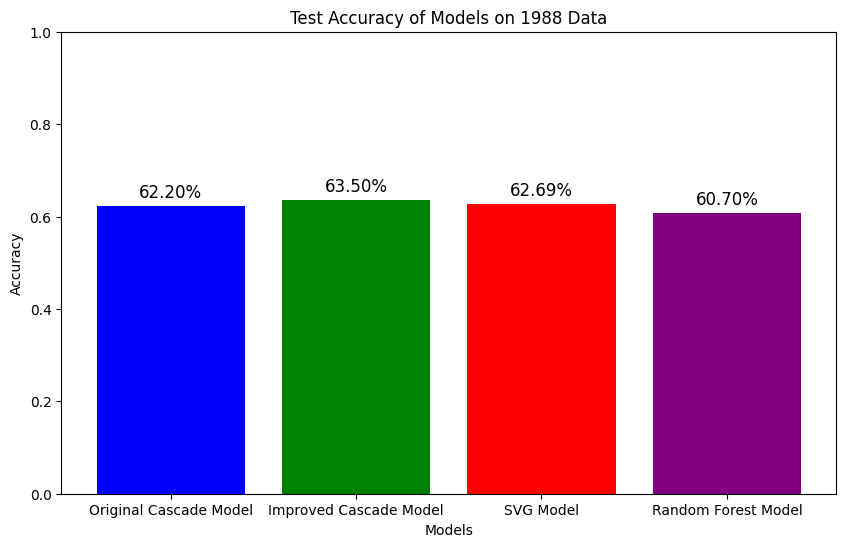

In [ ]:
import matplotlib.pyplot as plt
#Get accuracies of each model- Unseen data
models = ['Original Cascade Model', 'Improved Cascade Model', 'SVG Model', 'Random Forest Model']
accuracies = [0.622, 0.635, 0.6269, 0.607]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Models on 1988 Data')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)